In [1]:
import math

import numpy as np
import torch
import torch_geometric.nn.norm.batch_norm

from helper import *
from gnn import GNN
from heterognn import *

The State of the nth node is expressed by 4 real scalars:

v_n -> the voltage at the node
delta_n -> the voltage angle at the node (relative to the slack bus)
p_n -> the net active power flowing into the node
q_n -> the net reactive power flowing into the node


The physical characteristics of the network are described by the power flow equations:

p = P(v, delta, W)
q = Q(v, delta, W)

-> Relate local net power generation with the global state
-> Depends on the topology W of the grid

Electrical grid => Weighted Graph

Nodes in the graph produce/consume power

Edges represent electrical connections between nodes

State Matrix X element of  R(N x 4) => graph signal with 4 features
    => Each row is the state of the corresponding Node

Adjacency Matrix A => sparse matrix to represent the connections of each node, element of R(N x N), Aij = 1 if node i is connected to node j


We use the GNN as a mode phi(X, A, H)

We want to imitate the OPF solution p*
-> We want to minimize a loss L over a dataset T = {{X, p*}}

Objective Function:min arg H of sum over T L(p*,phi(X, A, H)) and we use L = Mean Squared error

Once GNN model phi is trained, we do not need the costly p* from pandapower to make predictions

Input Data X - R^(Nx4): Uniformly sample p_ref and q_ref of each load L with P_L ~ Uniform(0.9 * p_ref, 1.1 * p_ref) and Q_L ~ Uniform(0.9 * q_ref, 1.1 * q_ref)

Pseudocode for X and y in supervised learning:
for each P_L and Q_L:
    Create X with sub-optimal DCOPF results
    Create y with Pandapower calculating p* ACOPF with IPOPT


Spatio-Temporal GNN -> superposition of a gnn with spatial info and a temporal layer (Temporal Conv,LSTM etc.) ??

Bus => Node in GNN








In [22]:
# get lists of simbench codes
all_simbench_codes = sb.collect_all_simbench_codes()
all_simbench_codes

['1-complete_data-mixed-all-0-sw',
 '1-complete_data-mixed-all-1-sw',
 '1-complete_data-mixed-all-2-sw',
 '1-EHVHVMVLV-mixed-all-0-sw',
 '1-EHVHVMVLV-mixed-all-1-sw',
 '1-EHVHVMVLV-mixed-all-2-sw',
 '1-EHVHV-mixed-all-0-sw',
 '1-EHVHV-mixed-all-0-no_sw',
 '1-EHVHV-mixed-all-1-sw',
 '1-EHVHV-mixed-all-1-no_sw',
 '1-EHVHV-mixed-all-2-sw',
 '1-EHVHV-mixed-all-2-no_sw',
 '1-EHVHV-mixed-1-0-sw',
 '1-EHVHV-mixed-1-0-no_sw',
 '1-EHVHV-mixed-1-1-sw',
 '1-EHVHV-mixed-1-1-no_sw',
 '1-EHVHV-mixed-1-2-sw',
 '1-EHVHV-mixed-1-2-no_sw',
 '1-EHVHV-mixed-2-0-sw',
 '1-EHVHV-mixed-2-0-no_sw',
 '1-EHVHV-mixed-2-1-sw',
 '1-EHVHV-mixed-2-1-no_sw',
 '1-EHVHV-mixed-2-2-sw',
 '1-EHVHV-mixed-2-2-no_sw',
 '1-EHV-mixed--0-sw',
 '1-EHV-mixed--0-no_sw',
 '1-EHV-mixed--1-sw',
 '1-EHV-mixed--1-no_sw',
 '1-EHV-mixed--2-sw',
 '1-EHV-mixed--2-no_sw',
 '1-HVMV-mixed-all-0-sw',
 '1-HVMV-mixed-all-0-no_sw',
 '1-HVMV-mixed-all-1-sw',
 '1-HVMV-mixed-all-1-no_sw',
 '1-HVMV-mixed-all-2-sw',
 '1-HVMV-mixed-all-2-no_sw',
 '1-HVM

In [23]:
net = sb.get_simbench_net('1-HV-mixed--0-no_sw')#'1-HV-mixed--0-no_sw'

In [24]:
in_channels = 4
hidden_channels = 256
out_channels = 4
activation = "elu"
scaler = StandardScaler()
num_layers = 5
dropout = 0.0
jk = "last"
lr = 0.00001
layer_type = "TransConv"
# torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels, hidden_channels, num_layers, out_channels, dropout=dropout, norm=torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels),jk=jk,layer_type=layer_type, activation=activation)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ordered_dict = torch.load(r"C:\Users\canba\OneDrive\Masaüstü\OPFGNN\code\Models\Supervised\supervisedmodel.pt")

model.load_state_dict(ordered_dict)

<All keys matched successfully>

In [25]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor([[ 0.3095, -0.5524,  0.3097,  0.2161],
        [-0.4298, -0.2653,  0.2955, -0.1961],
        [ 0.0119,  0.1774, -0.1514, -0.0989],
        ...,
        [ 0.2016,  0.5492,  0.2451, -0.0977],
        [-0.3980, -0.2538, -0.3956, -0.2004],
        [-0.4785,  0.5502, -0.1866, -0.2399]], requires_grad=True)
Parameter containing:
tensor([-4.8516e-01, -1.6549e-01,  2.0859e-01,  4.4317e-01, -4.0218e-01,
         7.5104e-02, -1.4601e-01, -4.6575e-01, -1.1309e-01,  4.5851e-01,
         2.2650e-01,  3.4809e-01,  3.0619e-01,  1.7911e-02,  3.5580e-01,
         4.9894e-01, -2.1628e-01,  3.9977e-02, -7.5208e-03,  4.2041e-01,
        -2.1895e-01,  2.3228e-01,  7.1096e-02, -3.1837e-01, -4.3978e-01,
        -1.8905e-01,  3.4342e-01,  2.0580e-01, -1.6092e-01,  6.5101e-02,
        -2.1479e-01,  4.2486e-01,  4.4610e-01, -2.1051e-01, -7.0392e-02,
         4.4332e-01,  2.6700e-01,  6.0856e-02,  1.4605e-01,  1.1338e-01,
        -

In [26]:
net.bus

,name,vn_kv,type,zone,in_service,min_vm_pu,substation,voltLvl,subnet,max_vm_pu
0,EHV Bus 57,380.0,db,NaN,True,0.9,EHV_HV_substation_1,1,EHV1_HV1,1.1
2,EHV Bus 143,380.0,db,NaN,True,0.9,EHV_HV_substation_2,1,EHV1_HV1,1.1
4,EHV Bus 1649,220.0,db,NaN,True,0.9,EHV_HV_substation_3,1,EHV1_HV1,1.1
12,HV1 Bus 1,110.0,db,NaN,True,0.9,NaN,3,HV1,1.1
14,HV1 Bus 3,110.0,db,NaN,True,0.9,NaN,3,HV1,1.1
...,...,...,...,...,...,...,...,...,...,...
124,HV1 Bus 113,110.0,db,NaN,True,0.9,NaN,3,HV1,1.1
126,HV1 Bus 115,110.0,db,NaN,True,0.9,NaN,3,HV1,1.1
128,HV1 Bus 117,110.0,db,NaN,True,0.9,NaN,3,HV1,1.1
130,HV1 Bus 119,110.0,db,NaN,True,0.9,NaN,3,HV1,1.1


In [27]:
to_json('1-HV-mixed--0-no_sw')

In [28]:
net = sb.get_simbench_net('1-HV-mixed--0-no_sw')#'1-HV-mixed--0-no_sw'
#Replace all ext_grids but the first one with generators and set the generators to slack= false
ext_grids = [i for i in range(1,len(net.ext_grid.name.values))]
pp.replace_ext_grid_by_gen(net,ext_grids=ext_grids, slack=False)

#TODO: reactive power limits for gens?


#TODO: reactive power limits for sgens?



#NETWORK CONSTRAINTS

#Maximize the branch limits

#max_i_ka = list(net.line.max_i_ka.values)

#for i in range(len(max_i_ka)):
# max_i_ka[i] = max(max_i_ka)



#Maximize line loading percents
max_loading_percent = list(net.line.max_loading_percent.values)
for i in range(len(max_loading_percent)):
    max_loading_percent[i] = 100.0
net.line.max_loading_percent = max_loading_percent

#Maximize trafo loading percent
max_loading_percent = list(net.trafo.max_loading_percent.values)
for i in range(len(max_loading_percent)):
    max_loading_percent[i] = 100.0
net.trafo.max_loading_percent = max_loading_percent

#Maximize trafo3w loading percent
max_loading_percent = list(net.trafo3w.max_loading_percent.values)
for i in range(len(max_loading_percent)):
    max_loading_percent[i] = 100.0
net.trafo3w.max_loading_percent = max_loading_percent

#Cost assignment

pp.create_pwl_costs(net, [i for i in range(len(net.gen.name.values))],et="gen", points=[[[0, 20, 1], [20, 30, 2]] for _ in range(len(net.gen.name.values))])
pp.create_pwl_costs(net, [i for i in range(len(net.sgen.name.values))],et="sgen", points=[[[0, 20, 0.25], [20, 30, 0.5]] for _ in range(len(net.sgen.name.values))])
pp.create_pwl_costs(net, [i for i in range(len(net.ext_grid.name.values))],et="ext_grid", points=[[[0, 20, 2], [20, 30, 5]] for _ in range(len(net.ext_grid.name.values))])

pp.runopp(net,verbose=True)
net.res_bus

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.74 seconds
Objective Function Value = -1533.79 $/hr
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             64     Total Gen Capacity   3000000000.0       -3000000000.0 to 3000000000.0
Generators         3     On-line Capacity     3000000000.0       -3000000000.0 to 3000000000.0
Committed Gens     3     Generation (actual)   -845.3             438.9
Loads             56     Load                  -888.9             206.2
  Fixed           56       Fixed               -888.9             206.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches    

,vm_pu,va_degree,p_mw,q_mvar,lam_p,lam_q
0,1.100000,21.255777,176.751969,-32.559138,1.000000,7.400993e-22
2,1.092000,0.000000,688.520118,-331.755857,2.000000,7.539920e-21
4,1.100000,20.566608,-19.999826,-74.579263,1.061247,1.695006e-21
12,1.067333,20.747374,-0.000000,-0.000000,1.072429,1.100420e-01
14,1.084556,20.691407,3.000000,1.186000,1.061918,7.639524e-02
...,...,...,...,...,...,...
124,1.060835,20.368816,-3.370000,1.186000,1.097938,1.739239e-01
126,1.044952,18.158529,-13.990000,1.186000,1.151930,2.001434e-01
128,1.031897,15.487999,-9.010000,1.186000,1.217777,2.203168e-01
130,1.095114,24.337365,-20.010000,1.186000,0.991370,4.483060e-02


In [29]:
train_data, val_data, test_data = read_unsupervised_dataset('1-HV-mixed--0-no_sw')

Loading Network 1-HV-mixed--0-no_sw..


KeyboardInterrupt: 

In [ ]:
#train_data[0].has_isolated_nodes()
#train_data[0].has_self_loops()
#train_data[0].is_undirected()
x_dict = train_data[0].to_dict()
#to_json(train_dict)
ln = len(x_dict[("NB","-", "NB")]["edge_index"][0])
print(x_dict[("NB","-", "NB")]["edge_index"])#[:, :int(ln/2)]
x_dict

In [ ]:
net = sb.get_simbench_net('1-HV-mixed--0-no_sw')
idx_mapper, node_types_as_dict = extract_node_types_as_dict(net)
for key in node_types_as_dict:
    print(f"Bus Type: {key}")
    for i in range(len(node_types_as_dict[key])):
        #node_types_as_dict[key][i] = idx_mapper[node_types_as_dict[key][i]]
        print(str(node_types_as_dict[key][i]))
    print("-------------------------------")

In [ ]:
x_dict["PQ"]['x'][2]

In [ ]:
grids_available = []
for nw_name in all_simbench_codes:
        net = sb.get_simbench_net(nw_name)
        print("Trying Network named " + nw_name + "...")

        #dict_probs = pp.diagnostic(net,report_style='None')
        #for bus_num in dict_probs['multiple_voltage_controlling_elements_per_bus']['buses_with_gens_and_ext_grids']:
        #    net.gen = net.gen.drop(net.gen[net.gen.bus == bus_num].index)

        #OPERATIONAL CONSTRAINTS

        #Set upper and lower limits of active-reactive powers of loads
        min_p_mw_val, max_p_mw_val, min_q_mvar_val, max_q_mvar_val = [], [], [], []
        p_mw = list(net.load.p_mw.values)
        q_mvar = list(net.load.q_mvar.values)

        for i in range(len(p_mw)):
            min_p_mw_val.append(p_mw[i])
            max_p_mw_val.append(p_mw[i])
            min_q_mvar_val.append(q_mvar[i])
            max_q_mvar_val.append(q_mvar[i])

        net.load.min_p_mw = min_p_mw_val
        net.load.max_p_mw = max_p_mw_val
        net.load.min_q_mvar = min_q_mvar_val
        net.load.max_q_mvar = max_q_mvar_val

        #Replace all ext_grids but the first one with generators and set the generators to slack= false
        ext_grids = [i for i in range(1,len(net.ext_grid.name.values))]
        pp.replace_ext_grid_by_gen(net,ext_grids=ext_grids, slack=False)

        #TODO: reactive power limits for gens?


        #TODO: reactive power limits for sgens?



        #NETWORK CONSTRAINTS

        #Maximize the branch limits

        #max_i_ka = list(net.line.max_i_ka.values)

        #for i in range(len(max_i_ka)):
        # max_i_ka[i] = max(max_i_ka)



        #Maximize line loading percents
        max_loading_percent = list(net.line.max_loading_percent.values)
        for i in range(len(max_loading_percent)):
            max_loading_percent[i] = 100.0
        net.line.max_loading_percent = max_loading_percent

        #Maximize trafo loading percent
        max_loading_percent = list(net.trafo.max_loading_percent.values)
        for i in range(len(max_loading_percent)):
            max_loading_percent[i] = 100.0
        net.trafo.max_loading_percent = max_loading_percent

        #Maximize trafo3w loading percent
        max_loading_percent = list(net.trafo3w.max_loading_percent.values)
        for i in range(len(max_loading_percent)):
            max_loading_percent[i] = 100.0
        net.trafo3w.max_loading_percent = max_loading_percent

        #Cost assignment
        pp.create_pwl_costs(net, [i for i in range(len(net.gen.name.values))],et="gen", points=[[[0, 20, 1], [20, 30, 2]] for _ in range(len(net.gen.name.values))])
        pp.create_pwl_costs(net, [i for i in range(len(net.sgen.name.values))],et="sgen", points=[[[0, 20, 0.25], [20, 30, 0.5]] for _ in range(len(net.sgen.name.values))])
        pp.create_pwl_costs(net, [i for i in range(len(net.ext_grid.name.values))],et="ext_grid", points=[[[0, 20, 2], [20, 30, 5]] for _ in range(len(net.ext_grid.name.values))])

        try:
            pp.runpm_dc_opf(net) # Run DCOPP
        except pp.OPFNotConverged:
            text = "DC OPTIMAL POWERFLOW COMPUTATION DID NOT CONVERGE FOR NETWORK " + nw_name + ".SKIPPING THIS DATASET."
            print(text)
            continue
        print("GRID NAMED "+nw_name+" CONVERGES FOR DCOPF")
        grids_available.append(nw_name)


In [ ]:
for nw_name in grids_available:
    net = sb.get_simbench_net(nw_name)
    print(nw_name + ": Number of Buses = " + str(len(net.bus))) # dcopp on all grids directly

In [ ]:
grids_ready = []
for nw_name in all_simbench_codes[6:]:
    net = sb.get_simbench_net(nw_name)
    print("Trying Network named " + nw_name + "...")

    #OPERATIONAL CONSTRAINTS

    #Set upper and lower limits of active-reactive powers of loads
    min_p_mw_val, max_p_mw_val, min_q_mvar_val, max_q_mvar_val = [], [], [], []
    p_mw = list(net.load.p_mw.values)
    q_mvar = list(net.load.q_mvar.values)

    for i in range(len(p_mw)):
        min_p_mw_val.append(p_mw[i])
        max_p_mw_val.append(p_mw[i])
        min_q_mvar_val.append(q_mvar[i])
        max_q_mvar_val.append(q_mvar[i])

    net.load.min_p_mw = min_p_mw_val
    net.load.max_p_mw = max_p_mw_val
    net.load.min_q_mvar = min_q_mvar_val
    net.load.max_q_mvar = max_q_mvar_val

    #Replace all ext_grids but the first one with generators and set the generators to slack= false
    ext_grids = [i for i in range(1,len(net.ext_grid.name.values))]
    pp.replace_ext_grid_by_gen(net,ext_grids=ext_grids, slack=False)

    #TODO: reactive power limits for gens?


    #TODO: reactive power limits for sgens?



    #NETWORK CONSTRAINTS

    #Maximize the branch limits

    #max_i_ka = list(net.line.max_i_ka.values)

    #for i in range(len(max_i_ka)):
    # max_i_ka[i] = max(max_i_ka)



    #Maximize line loading percents
    max_loading_percent = list(net.line.max_loading_percent.values)
    for i in range(len(max_loading_percent)):
        max_loading_percent[i] = 100.0
    net.line.max_loading_percent = max_loading_percent

    #Maximize trafo loading percent
    max_loading_percent = list(net.trafo.max_loading_percent.values)
    for i in range(len(max_loading_percent)):
        max_loading_percent[i] = 100.0
    net.trafo.max_loading_percent = max_loading_percent

    #Maximize trafo3w loading percent
    max_loading_percent = list(net.trafo3w.max_loading_percent.values)
    for i in range(len(max_loading_percent)):
        max_loading_percent[i] = 100.0
    net.trafo3w.max_loading_percent = max_loading_percent

    #Cost assignment
    pp.create_pwl_costs(net, [i for i in range(len(net.gen.name.values))],et="gen", points=[[[0, 20, 1], [20, 30, 2]] for _ in range(len(net.gen.name.values))])
    pp.create_pwl_costs(net, [i for i in range(len(net.sgen.name.values))],et="sgen", points=[[[0, 20, 0.25], [20, 30, 0.5]] for _ in range(len(net.sgen.name.values))])
    pp.create_pwl_costs(net, [i for i in range(len(net.ext_grid.name.values))],et="ext_grid", points=[[[0, 20, 2], [20, 30, 5]] for _ in range(len(net.ext_grid.name.values))])

    #ac_converged = True

    #start_vec_name = ""
    #for init in ["pf", "flat", "results"]:
    #    try:
    #        pp.runopp(net, init=init)  # Calculate ACOPF with IPFOPT
    #    except pp.OPFNotConverged:
    #        if init == "results":
    #            text = "AC OPTIMAL POWERFLOW COMPUTATION DID NOT CONVERGE FOR NETWORK " + nw_name + ". SKIPPING THIS GRID."
    #            print(text)
    #            break
    #        continue
    #    start_vec_name = init
    #    ac_converged = True
    #    break
    #if ac_converged:
    #    print("GRID NAMED "+nw_name+" CONVERGES FOR ACOPF" + "WITH THE START VECTOR OPTION " + start_vec_name + ".")


    try:
        pp.runpm_ac_opf(net) # Run DCOPP
    except pp.OPFNotConverged:
        text = "AC OPTIMAL POWERFLOW COMPUTATION DID NOT CONVERGE FOR NETWORK " + nw_name + ".SKIPPING THIS DATASET."
        print(text)
        continue
    print("GRID NAMED "+nw_name+" CONVERGES FOR ACOPF" + "WITH THE START VECTOR OPTION " + ".")
    grids_ready.append(nw_name)


In [ ]:
for nw_name in grids_ready:
    net = sb.get_simbench_net(nw_name)
    print(nw_name + ": Number of Buses = " + str(len(net.bus))) #julia acopf on all grids directly

In [ ]:
for nw_name in grids_ready:
    net = sb.get_simbench_net(nw_name)
    print(nw_name + ": Number of Buses = " + str(len(net.bus))) #pp acopf on all grids directly

In [ ]:
for nw_name in grids_ready:
    net = sb.get_simbench_net(nw_name)
    print(nw_name + ": Number of Buses = " + str(len(net.bus))) #julia acopf

In [ ]:
for nw_name in grids_ready:
    net = sb.get_simbench_net(nw_name)
    print(nw_name + ": Number of Buses = " + str(len(net.bus))) #pp acopf

In [ ]:
dcopf_acopf_available_grid_names = ["1-HV-mixed--0-no_sw","1-HV-urban--0-no_sw", "1-MV-comm--0-no_sw", "1-MV-semiurb--0-no_sw"]

In [ ]:
datasets_df_as_list = []
for grid_name in dcopf_acopf_available_grid_names:
    print("Generating datasets for grid " + grid_name)
    while len(datasets_df_as_list) != 100:
        net = sb.get_simbench_net(grid_name)
        df = create_dataset_from_dcopf_and_acopf(net)
        if df is not None:
            datasets_df_as_list.append(df)
            print(str(len(datasets_df_as_list)) + " Dataset(s) Generated" + " for the grid " + grid_name)

    print("Saving the datasets for grid " + grid_name)
    path = os.path.dirname(os.path.abspath("gnn.ipynb")) + "\\data\\Supervised\\Training\\" + grid_name
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(0, len(datasets_df_as_list)):
        newpath = path + "\\Dataset-" + str(i) + ".csv"
        datasets_df_as_list[i].to_csv(newpath)

    datasets_df_as_list.clear()

In [ ]:
dcopf_available_grid_names = ["1-HVMV-mixed-all-0-no_sw", "1-HVMV-mixed-1.105-0-no_sw", "1-HVMV-mixed-2.102-0-no_sw","1-HVMV-mixed-4.101-0-no_sw", "1-HVMV-urban-all-0-no_sw", "1-HVMV-urban-2.203-0-no_sw", "1-HVMV-urban-3.201-0-no_sw", "1-HVMV-urban-4.201-0-no_sw", "1-HV-mixed--0-no_sw", "1-HV-urban--0-no_sw", "1-MVLV-rural-all-0-no_sw"]

In [ ]:
datasets_df_as_list = []
for grid_name in dcopf_available_grid_names:
    print("Generating datasets for grid " + grid_name)
    while len(datasets_df_as_list) != 100:
        net = sb.get_simbench_net(grid_name)
        df = create_dataset_from_dcopf(net)
        if df is not None:
            datasets_df_as_list.append(df)
            print(str(len(datasets_df_as_list)) + " Dataset(s) Generated" + " for the grid " + grid_name)

    print("Saving the datasets for grid " + grid_name)
    path = os.path.dirname(os.path.abspath("gnn.ipynb")) + "\\data\\Unsupervised\\Training\\" + grid_name
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(0, len(datasets_df_as_list)):
        newpath = path + "\\Dataset-" + str(i) + ".csv"
        datasets_df_as_list[i].to_csv(newpath)

    datasets_df_as_list.clear()

In this revised version of the compute_node_embeddings function, the node features are weighted by the reverse admittance values in the adjacency matrix before they are summed to compute the node embeddings. The resulting node embeddings will reflect the strength of the connections between the nodes.

To use the reverse admittance values as the edge weights, you would need to pass the Ybus matrix as the adjacency matrix when calling the compute_node_embeddings function. The Ybus matrix should be converted to a PyTorch tensor before passing it to the function.

use the reverse admittance values as edge weights, you can modify the computation of the node embeddings to weight the node features by the reverse admittance values.

# Define the node types
node_types = ['Slack Node', 'Generator Node', 'Load Node']

# Define the number of nodes of each type in the graph
num_nodes = {
    'Slack Node': 1,
    'Generator Node': 20,
    'Load Node': 99
}


In [ ]:
grid_names = [_ for _ in os.listdir(os.path.dirname(os.path.abspath("gnn.ipynb")) + "\\data\\Supervised\\")]


In [ ]:
graphdata_lst = read_multiple_supervised_datasets(grid_names)

In [ ]:
in_channels = 4
hidden_channels = 256
out_channels = 4
activation = "elu"
scaler = StandardScaler()
num_layers = 5
dropout = 0.0
jk = "last"
lr = 0.00001
layer_type = "TransConv"
# torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels, hidden_channels, num_layers, out_channels, dropout=dropout, norm=torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels),jk=jk,layer_type=layer_type, activation=activation)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ordered_dict = torch.load(r"C:\Users\canba\OneDrive\Masaüstü\OPFGNN\code\Models\Supervised\supervisedmodel.pt")

model.load_state_dict(ordered_dict)

In [ ]:
in_channels = 4
hidden_channels = 256
out_channels = 4
activation = "elu"
scaler = StandardScaler()
num_layers = 5
dropout = 0.0
jk = "last"
lr = 0.00001
layer_type = "TransConv"
# torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels, hidden_channels, num_layers, out_channels, dropout=dropout, norm=torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels),jk=jk,layer_type=layer_type, activation=activation)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

In [ ]:
lr

In [ ]:
for i in enumerate(model.modules()):
    print(i)
#print("Shape of the output " + str(np.shape(model(train_data[0].x, edge_index, edge_attr=edge_attr))))

In [ ]:
test_datasets_lst = []
for i, graphdata in enumerate(graphdata_lst):
    run = wandb.init(
    # set the wandb project where this run will be logged
    project="OPF-GNN-Supervised-Homo",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Homo-GNN",
    "num_layers": num_layers,
    "dataset": grid_names[i],
    "epochs": 1000,
    "activation": activation,
    "dropout": dropout,
    "in_channels": in_channels,
    "output_channels": out_channels,
    "hidden_channels": hidden_channels,
    "channel type": layer_type,
    "norm": "BatchNorm",
    "scaler": scaler

    }
    )
    num_epochs = wandb.run.config.epochs
    run.watch(model)
    grid_name = graphdata.grid_name
    run.config.dataset = grid_name
    train_data = graphdata.train_data
    run.config["number of busses"] = np.shape(train_data[0].x)[0]
    val_data = graphdata.val_data
    test_data = graphdata.test_data
    test_datasets_lst.append(test_data)
    training_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    validation_loader = DataLoader(val_data, batch_size=1, shuffle=True)
    #test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
    for _ in range(num_epochs):
        #train_one_epoch(i, optimizer, training_loader, model, nn.MSELoss(), edge_index, edge_weights)
        train_validate_one_epoch(_, grid_name, optimizer, training_loader, validation_loader, model, nn.MSELoss(), scaler)
    print("Training and Validation finished " + "for GraphData " + str(i) + ".")


In [ ]:
train_loader_lst = []
val_loader_lst = []
test_loader_lst = []
for i, graphdata in enumerate(graphdata_lst):

    # Divide training data into chunks, load into Dataloaders and append to the list of training loaders
    for train_data in divide_chunks(graphdata.train_data, 5):
        train_loader_lst.append(DataLoader(train_data, batch_size=1, shuffle=True))

    # Divide validation data into chunks, load into Dataloaders and append to the list of validation loaders
    for val_data in divide_chunks(graphdata.val_data, 5):
        val_loader_lst.append(DataLoader(val_data, batch_size=1, shuffle=True))

    # Append the test data to the list
    for test_data in divide_chunks(graphdata.test_data, 5):
        test_loader_lst.append(DataLoader(test_data, batch_size=1, shuffle=True))

print("Data Preparation finished.")

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr/100)

In [ ]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="OPF-GNN-Supervised-Homo",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Homo-GNN",
    "num_layers": num_layers,
    "epochs": 2000,
    "activation": activation,
    "dropout": dropout,
    "in_channels": in_channels,
    "output_channels": out_channels,
    "hidden_channels": hidden_channels,
    "channel type": layer_type,
    "norm": "BatchNorm",
    "scaler": scaler
    }
    )
"""
for _ in range(wandb.run.config.epochs):
    # Training
    random.shuffle(train_loader_lst)
    print("Training the model for epoch " + str(_))
    train_all_one_epoch(_, optimizer, train_loader_lst, model, nn.MSELoss())

    # Validation
    random.shuffle(val_loader_lst)
    print("Validating the model for epoch " + str(_))
    validate_all_one_epoch(_, val_loader_lst, model, nn.MSELoss())

    outputs = test_all_one_epoch(test_loader_lst, model, nn.MSELoss())
print("Training and Validation finished.")
"""


In [ ]:
outputs = test_all_one_epoch(test_loader_lst, model, nn.MSELoss())

In [ ]:
output,target = outputs[0]

In [ ]:
output

In [ ]:
target

In [ ]:
target

In [ ]:
path = r"C:\Users\canba\OneDrive\Masaüstü\OPFGNN\code\Models\Supervised\supervisedmodel.pt" #os.path.dirname(os.path.abspath("gnn.ipynb")) + "\\Models\\Supervised\\" + "basemodel.pt" #r"C:\Users\canba\OneDrive\Masaüstü\OPFGNN\code\Models\Supervised"
torch.save(model.state_dict(), "supervisedmodel.pt")
print("done")

In [ ]:
from pandapower.plotting.simple_plot import simple_plot
from pandapower.plotting.plotly.simple_plotly import simple_plotly
#simple_plot(net, plot_gens=True, plot_loads=True, plot_sgens=True, library="igraph")
simple_plotly(net, map_style="satellite")

In [ ]:
pp.runpm_ac_opf(net)
net.res_bus

In [ ]:
df = net.res_bus.drop(labels=['lam_p', 'lam_q'], axis=1)  # Drop columns

for i in range(len(df)):
    df.iloc[i][0] = 1.0  # net.bus.iloc[i][1]  # Set the initial bus voltages

for i in range(len(net.load)):
    idx_bus = net.load.iloc[i][1]  # Get the bus from the net.load dataframe

    for j in range(len(df.index)):  # Find the index of df with linear search where index = idx_bus
        if df.index[j] == idx_bus:
            idx_bus = j
            break

    df.iloc[idx_bus][3] = net.load.iloc[i][3]  # Set the q_mvar at idx_bus to that given in net.load

df['q_mvar'] = df['q_mvar'].fillna(0)  # Drop all nAn and replace them with 0

x_rows, x_cols = np.shape(df)
x = np.array(df).reshape(x_rows, x_cols)
df = torch.tensor(data=x, dtype=torch.float32)
df

In [ ]:
pp.runpm_ac_opf(net)
net.res_bus

In [ ]:
pp.runopp(net)
net.res_bus

In [ ]:
idx_mapper, node_types_as_dict = extract_node_types_as_dict(net)
node_types_as_dict

In [ ]:
in_channels = 4
hidden_channels = 256
out_channels = 4
activation = "elu"
scaler = StandardScaler()
num_layers = 5
dropout = 0.0
jk = "last"
lr = 0.00001
layer_type = "TransConv"
# torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels, hidden_channels, num_layers, out_channels, dropout=dropout, norm=torch_geometric.nn.norm.batch_norm.BatchNorm(hidden_channels),jk=jk,layer_type=layer_type, activation=activation)#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ordered_dict = torch.load(r"C:\Users\canba\OneDrive\Masaüstü\OPFGNN\code\Models\Supervised\supervisedmodel.pt")

model.load_state_dict(ordered_dict)

In [ ]:
model.parameters

In [3]:
grid_name = '1-HV-mixed--0-no_sw'

In [5]:
pp.runpm_ac_opf(net)


no costs are given - overall generated power is minimized


In [ ]:
net.res_bus

In [ ]:
net.sgen

In [ ]:
net.load

In [ ]:
net.trafo.loc[net.trafo.hv_bus == 4].sn_mva.values[0]

 HETEROGENEOUS GNN

In [2]:
_,_,data = generate_unsupervised_input('1-HV-mixed--0-no_sw')

In [3]:
x_dict, constraint_dict, _, _, _,scalers_dict = extract_unsupervised_inputs(data)
x_dict

{'SB': tensor([[0., 0., 0., 0.]], requires_grad=True),
 'PQ': tensor([[ 0.0000,  0.0000, -0.6404, -0.6338],
         [ 0.0000,  0.0000, -0.6507, -0.6481],
         [ 0.0000,  0.0000,  0.8055,  0.7649],
         [ 0.0000,  0.0000,  2.1738,  2.1652],
         [ 0.0000,  0.0000, -0.6414, -0.6210],
         [ 0.0000,  0.0000, -0.6656, -0.6152],
         [ 0.0000,  0.0000,  2.0733,  2.2768],
         [ 0.0000,  0.0000, -0.6468, -0.6104],
         [ 0.0000,  0.0000, -0.6559, -0.6241],
         [ 0.0000,  0.0000, -0.6617, -0.6302],
         [ 0.0000,  0.0000,  0.7727,  0.6422],
         [ 0.0000,  0.0000,  0.6930,  0.4308],
         [ 0.0000,  0.0000, -0.6375, -0.6245],
         [ 0.0000,  0.0000, -0.6739, -0.6231],
         [ 0.0000,  0.0000, -0.6444, -0.6495]], requires_grad=True),
 'PV': tensor([[ 5.9936,  0.0000,  0.5181,  0.5023],
         [ 2.3217,  0.0000,  0.5181,  0.5023],
         [-0.2028,  0.0000,  0.5237,  0.5145],
         [-0.2028,  0.0000,  0.0862,  0.0367],
         [-0.2028,

In [4]:
constraint_dict["SB"]

tensor([[ -38.,   38.,  350., -350.,  350., -350.,  350.]])

In [5]:
scalers_dict["SB"].inverse_transform(x_dict["SB"].detach().numpy())

array([[380.,   0.,   0.,   0.]], dtype=float32)

In [6]:
custom_inverse_transform(scalers_dict["SB"], constraint_dict["SB"].detach().numpy())

array([[ 342.,  418.,  350., -350.,  350., -350.,  350.]], dtype=float32)

220.0

In [10]:
constraint_dict["PV"]

tensor([[ 5.0593e+00,  6.7840e+00,  3.2033e+01, -2.1388e+01,  2.2534e+01,
         -5.4858e+01,  5.6010e+01],
        [ 1.7916e+00,  2.7901e+00,  2.7539e+01, -1.8250e+01,  1.9397e+01,
         -4.6939e+01,  4.8091e+01],
        [-4.5493e-01,  4.4304e-02,  8.3293e-01,  4.2301e-01,  7.7940e-01,
          3.9191e-01,  7.4746e-01],
        [-4.5493e-01,  4.4304e-02,  2.2923e+00, -5.6062e-01,  7.4322e-01,
         -5.3114e-01,  7.6964e-01],
        [-4.5493e-01,  4.4304e-02,  1.2060e+00,  1.5522e-01,  7.5381e-01,
          1.6027e-01,  7.5746e-01],
        [-4.5493e-01,  4.4304e-02,  1.4980e+01, -8.7797e+00,  5.7307e-01,
         -8.7549e+00,  5.7603e-01],
        [-4.5493e-01,  4.4304e-02,  1.9608e+00, -2.7505e-01,  1.7083e+00,
         -3.0037e-01,  1.6783e+00],
        [-4.5493e-01,  4.4304e-02,  1.2868e+01, -7.3598e+00,  2.6072e+00,
         -7.3745e+00,  2.5690e+00],
        [-4.5493e-01,  4.4304e-02,  3.7903e+00, -1.5125e+00,  7.6387e-01,
         -1.5230e+00,  7.4809e-01],
        [-

In [12]:
scalers_dict["SB"].mean_

array([380.,   0.,   0.,   0.])

In [2]:
save_unsupervised_inputs('1-HV-mixed--0-no_sw', 1000)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [3]:
inputs = load_unsupervised_inputs('1-HV-mixed--0-no_sw')

In [4]:
from torch_geometric.nn.resolver import activation_resolver

hidden_channels = 256
out_channels = 4
act_fn = "elu"
act = activation_resolver(act_fn, **({}))
scaler = StandardScaler()
num_layers = 3
dropout = 0.0
jk = "last"
lr = 0.00001
hetero_model = ACOPFGNN(hidden_channels, out_channels, num_layers, dropout, act_fn)
optimizer = torch.optim.Adam(hetero_model.parameters(), lr=lr)
#hetero_model(x, edge_idx_dict,edge_attr_dict)

In [5]:
train_ACOPF(hetero_model, optimizer, inputs, 1)

Epoch: 0


UnboundLocalError: local variable 'targets' referenced before assignment

In [5]:
out_dict = hetero_model(x_dict, constraint_dict ,edge_idx_dict, edge_attr_dict, bus_idx_neighbors_dict)
out_dict

defaultdict(list,
            {'PQ': tensor([[  0.9000,   0.0000,   2.9999,   1.1859],
                     [  0.9000,   0.0000,   2.9999,   1.1859],
                     [  0.9000,   0.0000,   7.0696,   4.2082],
                     [  0.9000,   0.0000,  36.1499,  14.2878],
                     [  0.9000,   0.0000,   2.9999,   1.1859],
                     [  0.9000,   6.0298,   2.9999,   1.1859],
                     [  0.9000,   0.0000,  34.5159,  16.3077],
                     [  0.9000,   0.0000,      nan,      nan],
                     [  0.9000,   9.1915,   2.9999,   1.1859],
                     [  9.3571, -10.2756, -17.9997,  29.9325],
                     [  0.9000,   0.0000,   2.9999,   1.1859],
                     [  0.9000,   0.0000,      nan,      nan],
                     [  0.9000,   0.0000,      nan,      nan],
                     [  0.9000,   0.0000,   2.9999,   1.1859],
                     [  0.9000,   0.0000,   2.9999,   1.1859],
                     [  0.9000,

In [8]:
x_dict["SB"][0][1]

tensor(0.)

In [8]:
for node_type, node_features in out_dict.items():
    print(f"{node_type}: {node_features.size()}")

SB: torch.Size([1, 4])
PQ: torch.Size([16, 4])
PV: torch.Size([42, 4])
NB: torch.Size([5, 4])


In [17]:
unsupervised_obj_fn(net, out_dict, bus_idx_neighbors_dict, sum(net.load.p_mw**2), sum(net.load.q_mvar**2))



tensor([ 6.1153e-06, -4.1852e-05], grad_fn=<_CvxpyLayerFnFnBackward>)


Display of the customizable Sigmoid

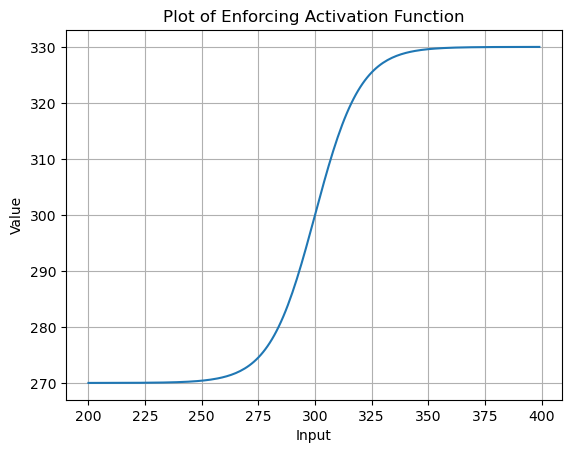

In [3]:
import matplotlib.pyplot as p
def custom_sigmoid_slope(x, lower_bound, upper_bound, slope=0.1):
    # Scale and shift the sigmoid function
    scaled_sigmoid = 1 / (1 + torch.exp(-slope * (x - (lower_bound + upper_bound) / 2)))

    # Scale and shift the result to fit within the specified lower_bound and upper_bound
    scaled_sigmoid = (scaled_sigmoid - 0.5) * (upper_bound - lower_bound) + (lower_bound + upper_bound) / 2

    return scaled_sigmoid

lst = []
min_val = 270
max_val = 330
for i in range(200,400,1):
    val = custom_sigmoid_slope(torch.tensor(i), min_val, max_val, 0.1)
    lst.append(val)

# Now, plot the values in lst
p.plot(range(200, 400, 1), lst)
p.xlabel('Input')
p.ylabel('Value')
p.title('Plot of Enforcing Activation Function')
p.grid(True)
p.show()